In [188]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import time
import ipywidgets as wg
from ipywidgets import interact
from IPython.display import display
import networkx as nx
from src.environment import Environment
from src.runner import runner
from src.helpers import confidence_interval, what_informality
import pickle
from sklearn import preprocessing
import random
import json
from matplotlib.dates import DateFormatter
import datetime

In [189]:
style.use('seaborn-white')

### 1 load general the parameters

In [190]:
with open('parameters/parameters.json') as json_file:
    parameters = json.load(json_file)

parameters['data_output'] = 'csv_light'
parameters['number_of_agents'] = 100000

In [191]:
parameters['number_of_agents']

100000

In [192]:
initial_agents = max(round((310 / (3740026 / parameters['number_of_agents']) * 100/14)), 20) # 310 cases / (population / agent) * 1 / 14% detected cases
initial_agents

59

In [193]:
# expand lockdown days 
parameters['lockdown_days'] = [x for x in range(0, parameters['time'])]

In [194]:
parameters['total_initial_infections'] = [x for x in range(initial_agents)]

In [195]:
#parameters["physical_distancing_multiplier"] = [0.95 for x in range(0, parameters['time'])]

In [196]:
#parameters["visiting_recurring_contacts_multiplier"] = parameters["visiting_recurring_contacts_multiplier"] + [parameters["visiting_recurring_contacts_multiplier"][-1] for x in range(len(parameters["visiting_recurring_contacts_multiplier"]), parameters['time'])]

In [197]:
range(len(parameters["visiting_recurring_contacts_multiplier"]), parameters['time'])

range(350, 350)

### 2 load neighbourhood data

In [198]:
with open('parameters/district_data_100k.json') as json_file:
    neighbourhood_data = json.load(json_file)

### Run 3 scenarios:

Lockdown regulation changes: 


* From 1 May level 4
* From 1 June level 3


1. No intervention
2. Formal lockdown
3. Informal lockdown 

First, initialise via pickle 

In [199]:
data = open('seed_22_forjoeri.pkl', "rb")
list_of_objects = pickle.load(data)
environment_base = list_of_objects[0]

data = open('seed_22_forjoeri.pkl', "rb")
list_of_objects = pickle.load(data)
environment_formal = list_of_objects[0]

data = open('seed_22_forjoeri.pkl', "rb")
list_of_objects = pickle.load(data)
environment_informal = list_of_objects[0]

scenarios = ['baseline', 'formal_lockdown', 'informal_lockdown']
environments = [environment_base, environment_formal, environment_informal]

Correct parameters from pickle. 

In [200]:
for env in environments: 
    env.parameters['time'] = parameters['time']
    env.parameters['probability_transmission']= parameters['probability_transmission']#!!!!###!!!###
    env.parameters['number_of_agents'] = 100000 #!!!!###!!!###
    env.parameters['data_output']=parameters['data_output']#!!!!###!!!###
    env.parameters["total_initial_infections"]=parameters["total_initial_infections"]
    env.parameters['informality_dummy']=parameters["informality_dummy"] 
    env.parameters["lockdown_days"]  = parameters["lockdown_days"] 
    env.parameters["health_system_capacity"] =parameters["health_system_capacity"]
    env.parameters['total_initial_infections'] = parameters['total_initial_infections']
    
    # ADD NEW PARAMETER
    env.parameters["perc_infections_detects"] = 1.0#parameters['perc_infections_detects']
    # ADD NEWLY DETECTED CASES
    env.newly_detected_cases = [0 for x in range(parameters['time'])]
    
    # CHANGE POLICY PARAMETERS
    env.parameters["physical_distancing_multiplier"] = parameters["physical_distancing_multiplier"]
    env.parameters["visiting_recurring_contacts_multiplier"] = parameters["visiting_recurring_contacts_multiplier"]
    env.parameters["likelihood_awareness"] = parameters["likelihood_awareness"]
    env.parameters["gathering_max_contacts"] = parameters["gathering_max_contacts"]

In [201]:
data_folder = 'measurement/baseline_100k/'
seed = 22

In [202]:
for env, sc in zip(environments, scenarios):
    if sc == 'baseline':
        env.parameters["lockdown_days"] = [0 for x in parameters["lockdown_days"]]
    if sc == 'formal_lockdown':
        env.parameters['informality_dummy'] = 0.0
    
    if sc == 'informal_lockdown':
        env.parameters['informality_dummy'] = 1.0
    
    if env.parameters['informality_dummy'] == 1.0:
        for agent in env.agents:
            agent.informality = what_informality(agent.district, neighbourhood_data) * parameters["informality_dummy"]
        
    env = runner(env, 0, data_folder=data_folder, data_output=env.parameters['data_output'])
    
    if parameters["data_output"] == 'csv_light':
        pd.DataFrame(env.infection_quantities).to_csv('{}seed{}/quantities_state_time_{}.csv'.format(data_folder,
                                                                                                      seed, sc))

1150
882
896


In [203]:
environments[2].parameters['informality_dummy']

1.0

In [204]:
scenarios[2]

'informal_lockdown'

### Analyse data for the three scenarios

In [205]:
data_scenarios = [pd.read_csv('{}seed{}/quantities_state_time_{}.csv'.format(data_folder, seed, sc), index_col=0) for sc in scenarios]

In [206]:
start_date = datetime.datetime(2020, 3, 29)
dates = [start_date + datetime.timedelta(days=x) for x in data_scenarios[0].index]

In [207]:
multiplication_factor = 37.40026
detection_m_factor = multiplication_factor * 0.14

### Compare to the actual case numbers for cape town:

In [208]:
detected_cases = pd.read_csv('input_data/detected_cases_cape_town_metro.csv')['Cases']
#tests_conducted = pd.read_csv('input_data/detected_cases_cape_town_metro.csv')['Cases']
#detected_cases.plot()

In [209]:
dc = pd.Series([x for x in detected_cases] + [np.NaN for x in range(parameters['time'] - 78)])

Text(0.5, 0, 'Date')

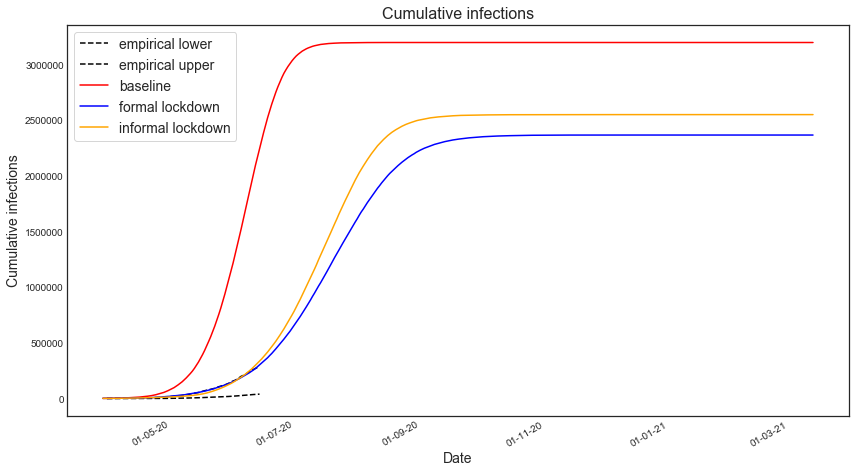

In [210]:
fig, ax = plt.subplots(figsize=(14,8))

ax.set_title('Cumulative infections', fontsize='16')

ax.plot(dates, dc, 'k--', label='empirical lower')

ax.plot(dates, dc * 100/14, 'k--', label='empirical upper')


#ax.plot(dates, (data_scenarios[0]['e'] + data_scenarios[0]['i1'] + data_scenarios[0]['i2']) * multiplication_factor, label='baseline')
ax.plot(dates, (data_scenarios[0]['detected'].cumsum() * multiplication_factor), label='baseline', 
        color='red', linestyle='-')

#ax.plot(dates, (data_scenarios[1]['e'] + data_scenarios[1]['i1'] + data_scenarios[1]['i2']) * multiplication_factor, label='formal')
ax.plot(dates, (data_scenarios[1]['detected'].cumsum() * multiplication_factor), label='formal lockdown', 
        color='blue', linestyle='-')


#ax.plot(dates, (data_scenarios[2]['e']  + data_scenarios[2]['i1'] + data_scenarios[2]['i2']) * multiplication_factor, label='informal')
ax.plot(dates, (data_scenarios[2]['detected'].cumsum() * multiplication_factor), label='informal lockdown', 
        color='orange', linestyle='-')

myFmt = DateFormatter("%d-%m-%y")
ax.xaxis.set_major_formatter(myFmt)

## Rotate date labels automatically
fig.autofmt_xdate()


ax.legend(loc='best', fontsize='14', frameon=True)
ax.set_ylabel('Cumulative infections', fontsize='14')
ax.set_xlabel('Date', fontsize='14')

Text(0.5, 0, 'Date')

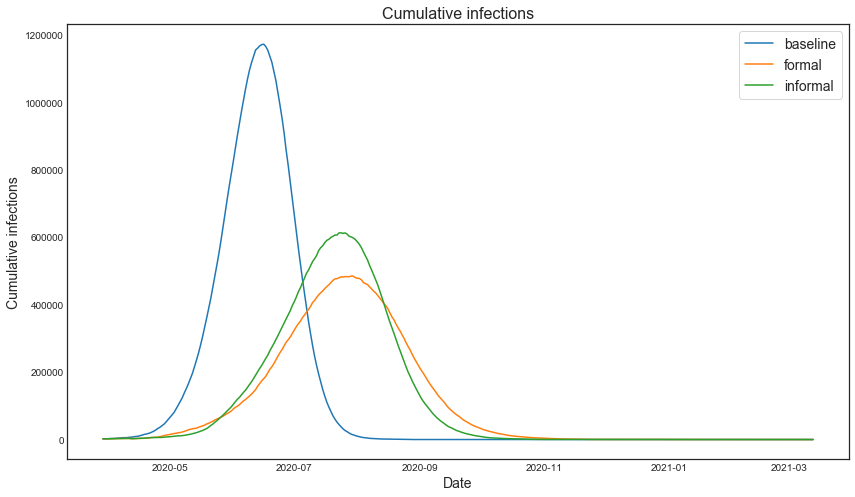

In [211]:
fig, ax = plt.subplots(figsize=(14,8))

ax.set_title('Cumulative infections', fontsize='16')

#ax.plot(dates, detected_cases, 'k--', label='empirical lower')

#ax.plot(dates, detected_cases * 100/14, 'k--', label='empirical upper')


ax.plot(dates, (data_scenarios[0]['e'] + data_scenarios[0]['i1'] + data_scenarios[0]['i2']) * multiplication_factor, label='baseline')
# ax.plot(dates, (data_scenarios[0]['detected'].cumsum() * multiplication_factor), label='baseline', 
#         color='red', linestyle='-')

ax.plot(dates, (data_scenarios[1]['e'] + data_scenarios[1]['i1'] + data_scenarios[1]['i2']) * multiplication_factor, label='formal')
# ax.plot(dates, (data_scenarios[1]['detected'].cumsum() * multiplication_factor), label='formal lockdown', 
#         color='blue', linestyle='-')


ax.plot(dates, (data_scenarios[2]['e']  + data_scenarios[2]['i1'] + data_scenarios[2]['i2']) * multiplication_factor, label='informal')
# ax.plot(dates, (data_scenarios[2]['detected'].cumsum() * multiplication_factor), label='informal lockdown', 
#         color='orange', linestyle='-')

# myFmt = DateFormatter("%d-%m-%y")
# ax.xaxis.set_major_formatter(myFmt)

# ## Rotate date labels automatically
# fig.autofmt_xdate()


ax.legend(loc='best', fontsize='14', frameon=True)
ax.set_ylabel('Cumulative infections', fontsize='14')
ax.set_xlabel('Date', fontsize='14')